In [5]:
import os
import cv2
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fracture
import DIC.DIC as dic
#csv파일 형식 바꾸기!

"""setting values"""
path = r'E:\experiment data\aluminum\2021-03-25\faruv_tension_2/'

slice_x1 = 71
slice_x2 = 142
slice_y1 = 414
slice_y2 = 661
file_list = os.listdir(path+'/img')

result = []
for file in file_list:
    if file.endswith(".jpg"):
        im = cv2.imread(os.path.join(path,'img', file), cv2.IMREAD_GRAYSCALE)
        im_calculate = np.array(im)
        img_box = im_calculate[slice_y1:slice_y2, slice_x1:slice_x2]

        ave = np.average(img_box)
        result = np.append(result, [ave])

result= result - result[0]
print('Finish')


Run complete
Finish


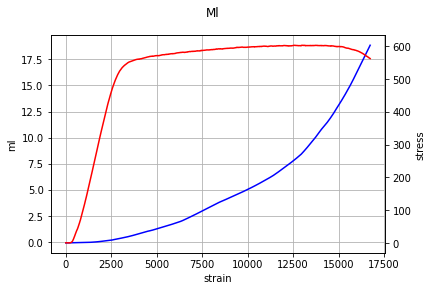

In [6]:
ml_avg = np.copy(result)
from scipy.signal import savgol_filter

max_range = 16741
tension_data = np.array(pd.read_csv(path+'/tension.csv', encoding='CP949'))

time, strain, stress = tension_data[:, 0], tension_data[:, 4]*10/25, tension_data[:, 3]*3000/18
ml_avg[3545:] = ml_avg[3545:] + 1.4
stress = savgol_filter(stress[0:max_range],201,1)
strain = savgol_filter(strain[0:max_range],201,1)
ml_avg = savgol_filter(ml_avg[0:max_range],2001,1)
ml_avg =  ml_avg[0:max_range]
time = time[0:max_range]


title = 'ml'
fig, ax = plt.subplots()
ax1 = ax.twinx()
fig.suptitle('Ml')
ax.set_xlabel('strain')
ax.set_ylabel('ml')
ax1.set_ylabel('stress')
ax.plot(time, ml_avg, color='b', label="Average Ml(Same mask)")
ax1.plot(time, stress, color='r', label=" stress")
ax.grid()
plt.savefig(path+'/%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)

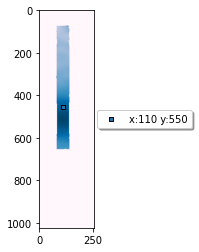

,image_name,voltage_strain,using_DIC_mask_strain,voltage_stress,using_DIC_mask_average,local_ml,local_ee,DIC_exx,DIC_eyy,DIC_exy,ml_average
0,548.0,-0.001461,0.003942,30.726590,0.104879,0.1975,0.003024,0.000329,0.000215,0.000007,-0.067522
1,1491.0,0.014368,0.004478,227.977444,0.417805,0.4225,0.002760,-0.001659,0.002232,0.000462,-0.014546
2,2061.0,0.022853,0.005391,367.122663,0.457038,0.5575,0.005668,-0.001575,0.004253,0.000366,0.079617
3,2901.0,0.036573,0.008778,517.912911,0.622782,0.5225,0.008649,-0.001476,0.007182,0.000251,0.318637
4,3441.0,0.045828,0.011461,550.132740,0.800843,1.1375,0.012745,-0.002452,0.010375,-0.000279,0.518259
5,3561.0,0.047442,0.012632,552.994960,0.085184,0.3500,0.011568,-0.003212,0.011275,-0.000256,0.570035
6,5881.0,0.084284,0.034035,576.842448,1.078647,1.6175,0.035764,-0.012586,0.033138,0.000074,1.721310
7,6511.0,0.094339,0.040539,580.743692,1.560494,2.4075,0.042162,-0.014228,0.039737,-0.000408,2.122328
8,8821.0,0.131544,0.060327,592.838376,3.736867,5.2950,0.061772,-0.023585,0.059268,-0.000459,4.092293
9,9041.0,0.135159,0.062249,593.666344,4.154000,5.5825,0.064362,-0.024050,0.060898,-0.000553,4.259184


In [7]:
"""
Matlab코드 여러 Dic데이터있는경우
path = 'E:\experiment data\aluminum\2021-03-04\DIC_img\data'

for i=1:1:22
uu=handles_ncorr.data_dic.displacements(i).plot_u_cur_formatted;
vv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
exx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;
eyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;
exy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;

save([path,'/', num2str(i), '_exx', '.mat'],'exx')
save([path,'/', num2str(i), '_exy', '.mat'],'exy')
save([path,'/', num2str(i), '_eyy', '.mat'],'eyy')
save([path,'/', num2str(i), '_uu', '.mat'],'uu')
save([path,'/', num2str(i), '_vv', '.mat'],'vv')

end

"""

"""setting values"""

image = dic.load_file(path+'/DIC_img')

ref = image[list(image.keys())[0]]
ref_x, ref_y = 110, 550

ratio = 0.04

df = pd.DataFrame(columns=['image_name', 'voltage_strain','using_DIC_mask_strain','voltage_stress',
                           'using_DIC_mask_average', 'local_ml', 'local_ee','DIC_exx', 'DIC_eyy', 'DIC_exy','ml_average'])


for num in range(1,22+1):
    file_num = str(num)
    uu = io.loadmat(path+'/DIC_img/data/'+file_num+'_uu.mat')['uu']
    vv = io.loadmat(path+'/DIC_img/data/'+file_num+'_vv.mat')['vv']
    uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
    vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )

    exx = io.loadmat(path+'/DIC_img/data/'+file_num+'_exx.mat')['exx']
    eyy = io.loadmat(path+'/DIC_img/data/'+file_num+'_eyy.mat')['eyy']
    exy = io.loadmat(path+'/DIC_img/data/'+file_num+'_exy.mat')['exy']
    ee = fracture.effective_strain(exx, eyy, exy)
    exx_resize = cv2.resize(exx,(0,0),fx=2, fy=2 )
    eyy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
    exy_resize = cv2.resize(exy,(0,0),fx=2, fy=2 )
    ee_resize = cv2.resize(ee,(0,0),fx=2, fy=2 )

    ee_mask = np.where(ee_resize>0, 255, ee_resize*0).astype('uint8')
    ml_image = image[list(image.keys())[num]]
    mask_ml = dic.find_zone(cv2.copyTo(ml_image, ee_mask))[10:-10,10:-10]
    if num == 1:
        ref_image = cv2.copyTo(image[list(image.keys())[0]], cv2.imread(path+'/DIC_img/mask.png'))
        ref = dic.find_zone(ref_image)[10:-10,10:-10]
        gas_ref = cv2.GaussianBlur(ref,(0,0),5)

    gas = cv2.GaussianBlur(mask_ml[:,:,1],(0,0),5)

    cur_y = np.round(ref_y+vv_resize[ref_y,ref_x]/ratio,1).astype('int')
    cur_x = np.round(ref_x+uu_resize[ref_y,ref_x]/ratio,1).astype('int')

    local_ee = np.average(ee_resize[cur_y-10 : cur_y+10 , cur_x-10: cur_x+10])
    local_ml = np.average(ml_image[cur_y-10 : cur_y+10 , cur_x-10: cur_x+10]) - np.average(image[list(image.keys())[0]][ref_y-10 : ref_y+10 , ref_x-10 : ref_x+10])

    # if num > 6:
    #     local_ml = local_ml + 1.4

    image_name = int(list(image.keys())[num].split('_')[1])
    voltage_strain = strain[int(list(image.keys())[num].split('_')[1])]
    voltage_stress = stress[int(list(image.keys())[num].split('_')[1])]
    using_DIC_mask_strain = np.average(dic.find_zone(ee_resize)[10:-10,10:-10])
    using_DIC_mask_average = np.average(mask_ml[:,:,1])-np.average(ref)
    local_ml = local_ml
    local_ee = local_ee
    DIC_eyy = np.average(dic.find_zone(eyy))
    DIC_exx = np.average(dic.find_zone(exx))
    DIC_exy = np.average(dic.find_zone(exy))
    ml_average = ml_avg[int(list(image.keys())[num].split('_')[1])]
    row = pd.Series([image_name, voltage_strain,voltage_stress,using_DIC_mask_strain,
                     using_DIC_mask_average, local_ml, local_ee,DIC_exx, DIC_eyy, DIC_exy,ml_average],
                index=['image_name', 'voltage_strain','voltage_stress','using_DIC_mask_strain',
                       'using_DIC_mask_average', 'local_ml', 'local_ee','DIC_exx', 'DIC_eyy', 'DIC_exy','ml_average'])
    df = df.append(row, ignore_index=True)

    # fig, ax = plt.subplots(1, 3 , constrained_layout=True)
    # fig.suptitle(list(image.keys())[num] + 'strain : ' + str(np.round(strain[int(list(image.keys())[num].split('_')[1])],3)))
    #
    # ax0 = ax[0].imshow(cv2.addWeighted(ml_image[:,:,2],1, ee_mask,0.06,-40),cmap='gray')
    # ax[0].set_title('ML ROI')
    # ax[0].scatter(cur_x, cur_y,color='red', marker='s', s=10)
    #
    # ax1 = ax[1].imshow(ee_resize, cmap='jet', vmin=0, vmax=0.25)
    # ax[1].set_title('Effective\n strain')
    # ax[1].scatter(cur_x, cur_y,color='white', marker='s', s=10)
    # plt.colorbar(ax1,ax=ax[1])
    #
    # gas = cv2.flip(gas,0)
    # ax[2].imshow(gas)
    # ax2 = ax[2].contourf(gas,cmap='jet', vmin=75, vmax=116)
    # ax3 = ax[2].contour(gas,colors='black',linewidths=1)
    # ax[2].invert_yaxis()
    # plt.colorbar(ax2, ax=ax[2])
    # # ax[2].axis('off')
    # ax[2].set_title('ML')
    # # plt.savefig(path+'/'+list(image.keys())[num]+'.png', dpi=300)
    #
    #
    # plt.show()
    # plt.close()


plt.imshow(ee_resize, cmap='PuBu', vmin=0, vmax=0.25) ##네킹부분 국부
plt.scatter(cur_x, cur_y, marker='s', s=10  ,label='x:'+str(ref_x) + ' y:'+str(ref_y), edgecolors='black')
plt.legend()
plt.legend(loc='center right', bbox_to_anchor=(2.9, 0.5), fancybox=True, shadow=True)
# plt.savefig(path+'/국부 점으로찍은위치6.png', dpi=300)
plt.show()
plt.close()
df

In [8]:
"""최소자승법"""
lms_list = []
for k in range(0,5000):
    i = k*0.1
    lms = np.sum(((i * df.local_ee) - df.ml_average)**2)
    lms_list.append(lms)
np.argmin(lms_list)

885

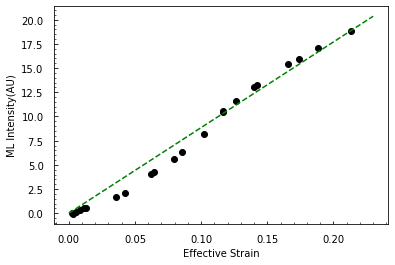

In [9]:
plt.plot([0,0.23],[0,0.23*0.1*885], 'g--')
plt.scatter(df.local_ee, df.ml_average, color='black')
# plt.plot(df.using_DIC_mask_strain, df.ml_average, color='black')
plt.xlabel('Effective Strain')
plt.ylabel('ML Intensity(AU)')
# plt.grid()
# plt.xlim(0,0.15)
plt.tick_params(direction='in', pad=10,which='both')
plt.minorticks_on()
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.savefig(path+'/ee_ml.png', dpi=300, bbox_inches='tight',  pad_inches=0)

b = np.vstack((np.arange(0,0.23,0.0005), np.arange(0,0.23,0.0005)*88.5)).transpose()

np.savetxt(path+'/effective_strain_ml_파이날.csv',b)


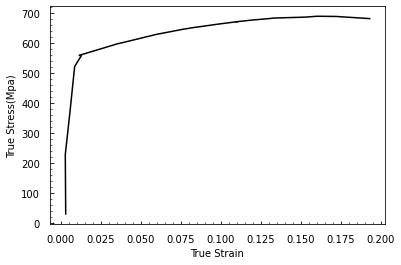

In [10]:
# title = 'Effective strain vs Stress'
plt.tick_params(direction='in', pad=10,which='both')
plt.minorticks_on()
stress, strain = fracture.true_ss(df.voltage_stress, df.local_ee)

plt.plot(strain, stress, color='black')
plt.xlabel('True Strain')
plt.ylabel('True Stress(Mpa)')
# plt.grid()
ax.set_xlim(0,)
ax.set_ylim(0,)
plt.savefig(path+'/true_%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)
plt.show()

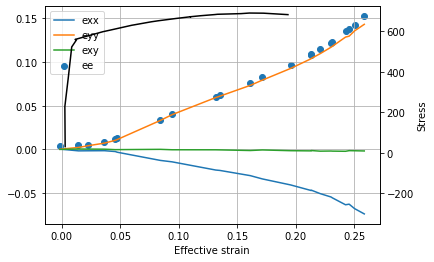

In [11]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
title = 'Effective strain vs Strain'
ax1.plot(strain, stress, color='black')
ax.plot(df.voltage_strain, df.DIC_exx, label='exx')
ax.plot(df.voltage_strain, df.DIC_eyy,label='eyy')
ax.plot(df.voltage_strain, df.DIC_exy, label='exy')
ax.scatter(df.voltage_strain, df.using_DIC_mask_strain, label='ee')
ax.set_xlabel('Effective strain')
ax1.set_ylabel('Stress')
ax1.set_ylim(-350,)
ax.legend()
ax.grid()
plt.savefig(path+'/%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)
plt.show()


In [12]:
ml_df = pd.read_pickle('only_ml.pkl')
ml_df

FileNotFoundError: [Errno 2] No such file or directory: 'only_ml.pkl'

In [ ]:
plt.plot(df.local_ee, df.voltage_stress, color='red',label='dic_ml')
plt.plot(ml_df.local_ee, ml_df.voltage_stress, color='blue',label='only ml')
plt.legend()
plt.grid()
title = '비교샷'
plt.savefig(path+'/%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)